## First generate an image with Flux Schnell

In [1]:
import torch
from diffusers import FluxFillPipeline, FluxPipeline,DiffusionPipeline, FluxFillPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from utils import preprocess_image,pil_to_cv2,cv2_to_pil, show_image_cv2, clear_gpu_memory
import copy
from diffusion_utils import load_pipeline,generate_outpaint,fix_mask, fix_inpaint_mask, vis_inpaint_strategy,composite_with_mask
import torch
from transformers import T5EncoderModel
from dust3r_infer import get_focals
from image_utils import *

GEN = False
USE_SDXL = False

IMAGE_SIZE = 1024
if GEN == True:
	pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
	pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

	prompt = "a town square in a city with a person standing in the center"
	image = pipe(
		prompt,
		guidance_scale=0.0,
		num_inference_steps=4,
		max_sequence_length=256,
		generator=torch.Generator("cpu").manual_seed(0)
	).images[0]
	image.save("middle.jpg")
	clear_gpu_memory()
	focals = get_focals('middle.jpg', 512)
	source_image_cv2 = pil_to_cv2(image)
	show_image_cv2(source_image_cv2)



/home/cedric/anaconda3/envs/world_recipe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
/!\ module trimesh is not installed, cannot visualize results /!\


/home/cedric/PanoramaGenInpaint/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Use Dust3R to estimate the FOV and map it to the equirectangular image

In [2]:
if GEN : 
	h_fov = focal_to_fov(focals[0], 512)  # Assuming 512 is your reference dimension
	print(f"Horizontal FOV: {h_fov} degrees")
	equirectangular_image,non_wrapped = image_to_equirectangular(source_image_cv2, h_fov, 2028*4,1024*4,wrap_around=True)
	cv2_to_pil(equirectangular_image).save("initial_pano_with_back.png")
	cv2_to_pil(non_wrapped).save("initial_pano_center.png")
	show_image_cv2(equirectangular_image)

## Visualisation of rough inpainting regions

/home/cedric/PanoramaGenInpaint/image_utils.py:362: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_x = world_x / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_y = world_y / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: invalid value encountered in divide
  persp_ndc_y = world_y / world_z


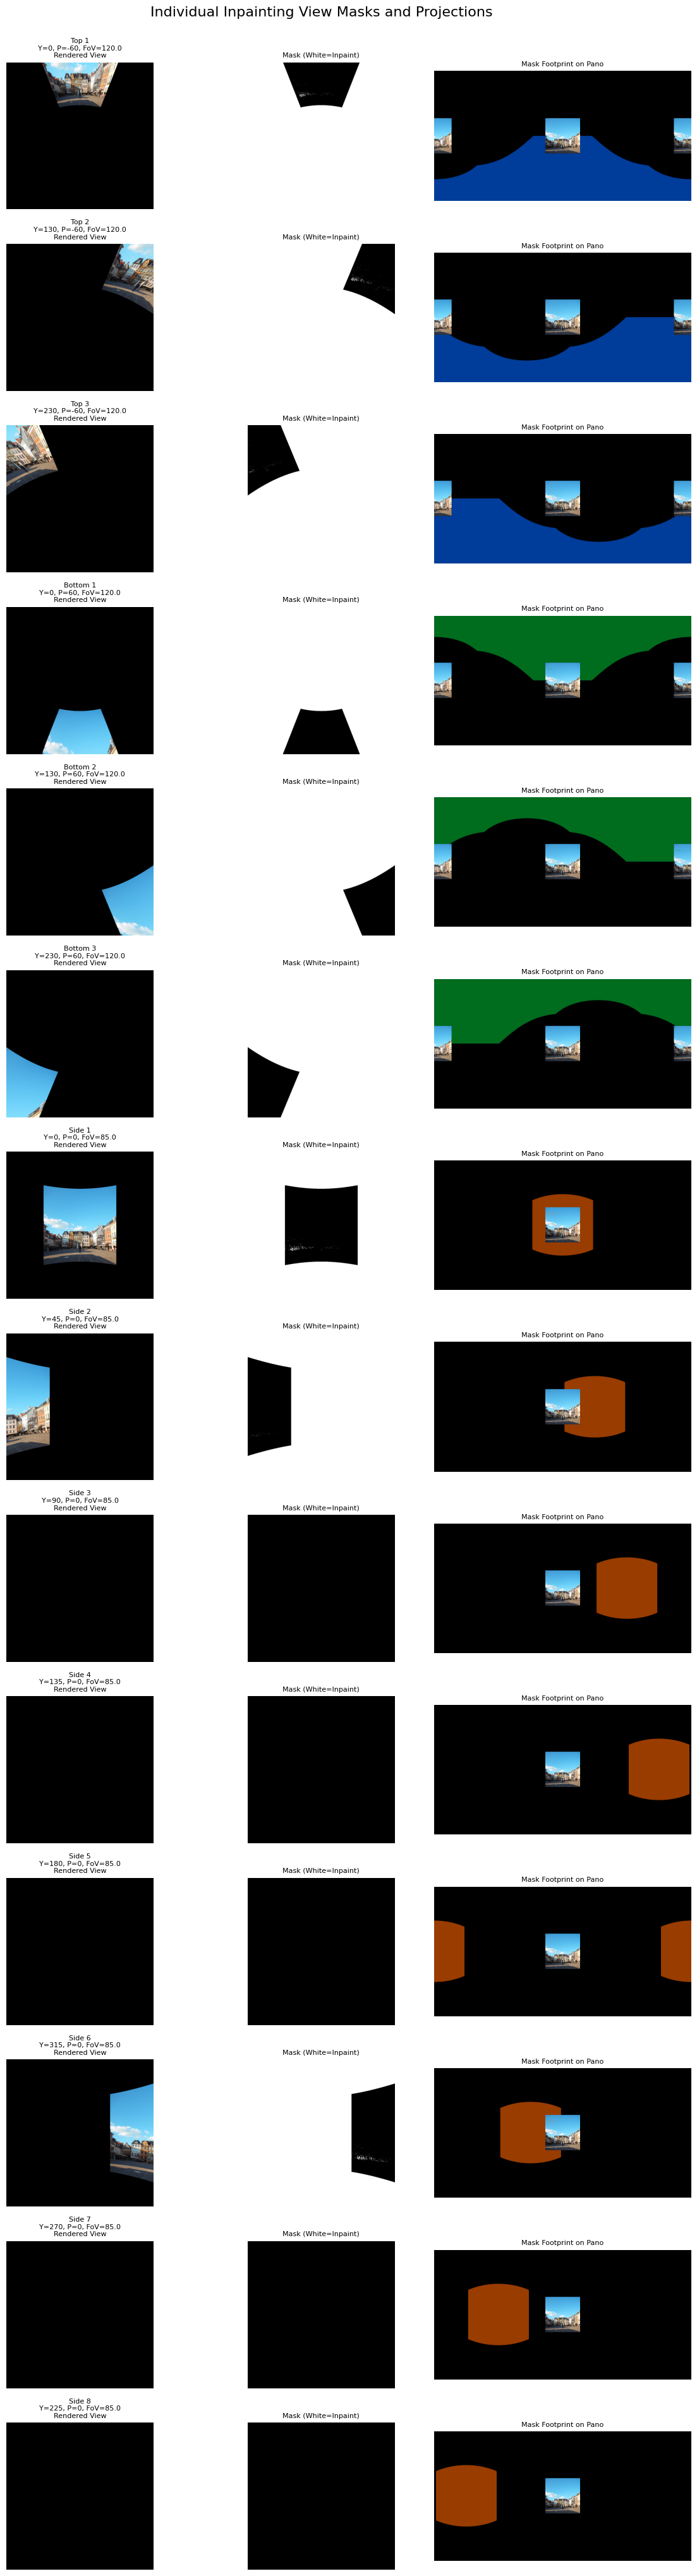

In [3]:
all_views_data = vis_inpaint_strategy()

## Approach C)  

In [4]:
if USE_SDXL:
	pipeline = load_sdxl_pipeline()
else:
	pipeline = load_pipeline()

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.39it/s]


Using four bit.


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
The module 'T5EncoderModel' has been loaded in `bitsandbytes` 4bit and conversion to torch.bfloat16 is not supported. Module is still in 4bit precision.
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 4bit and conversion to torch.bfloat16 is not supported. Module is still in 4bit precision.


## Perform iterative Inpainting (First Top and Bottom views)

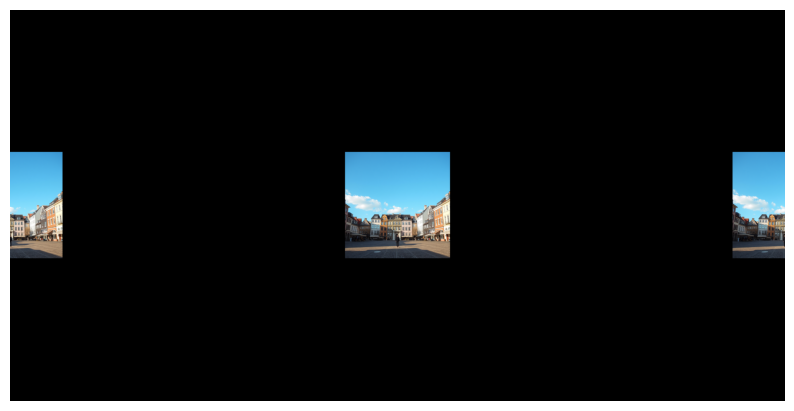

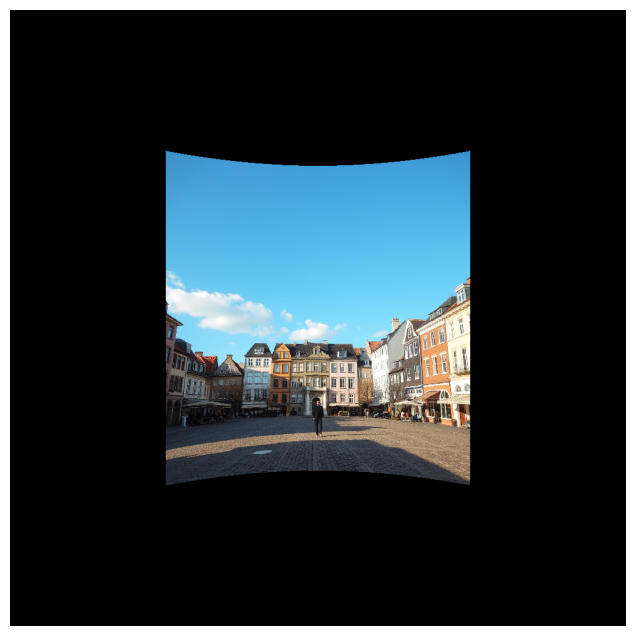

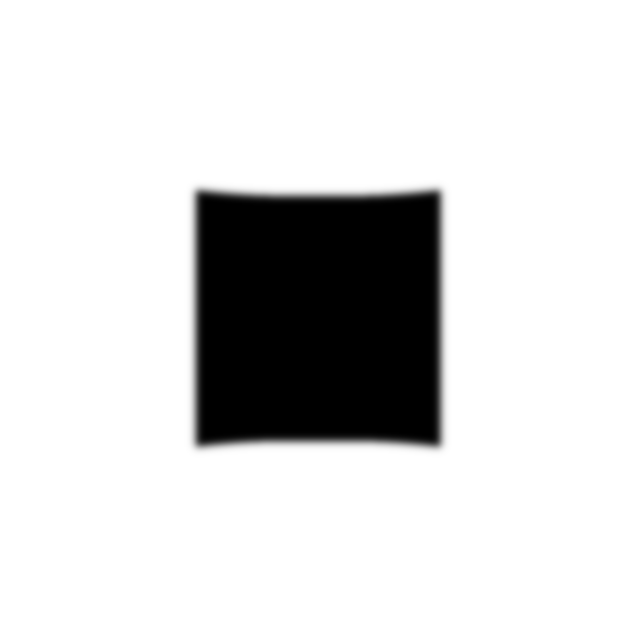

Render image shape: (1024, 1024)(1024, 1024)


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


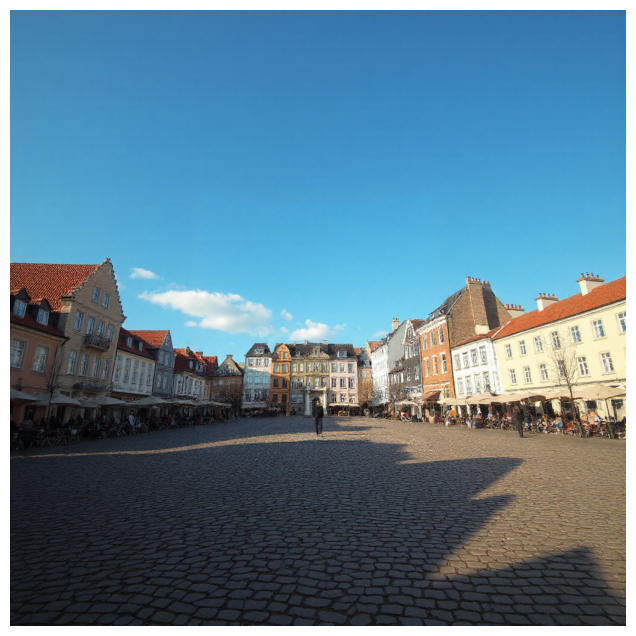

Mask min: 0.0, max: 1.0
Projected 2777874 pixels from perspective to equirect with yaw=0, pitch=0
Projected 2777874 pixels from perspective to equirect with yaw=0, pitch=0


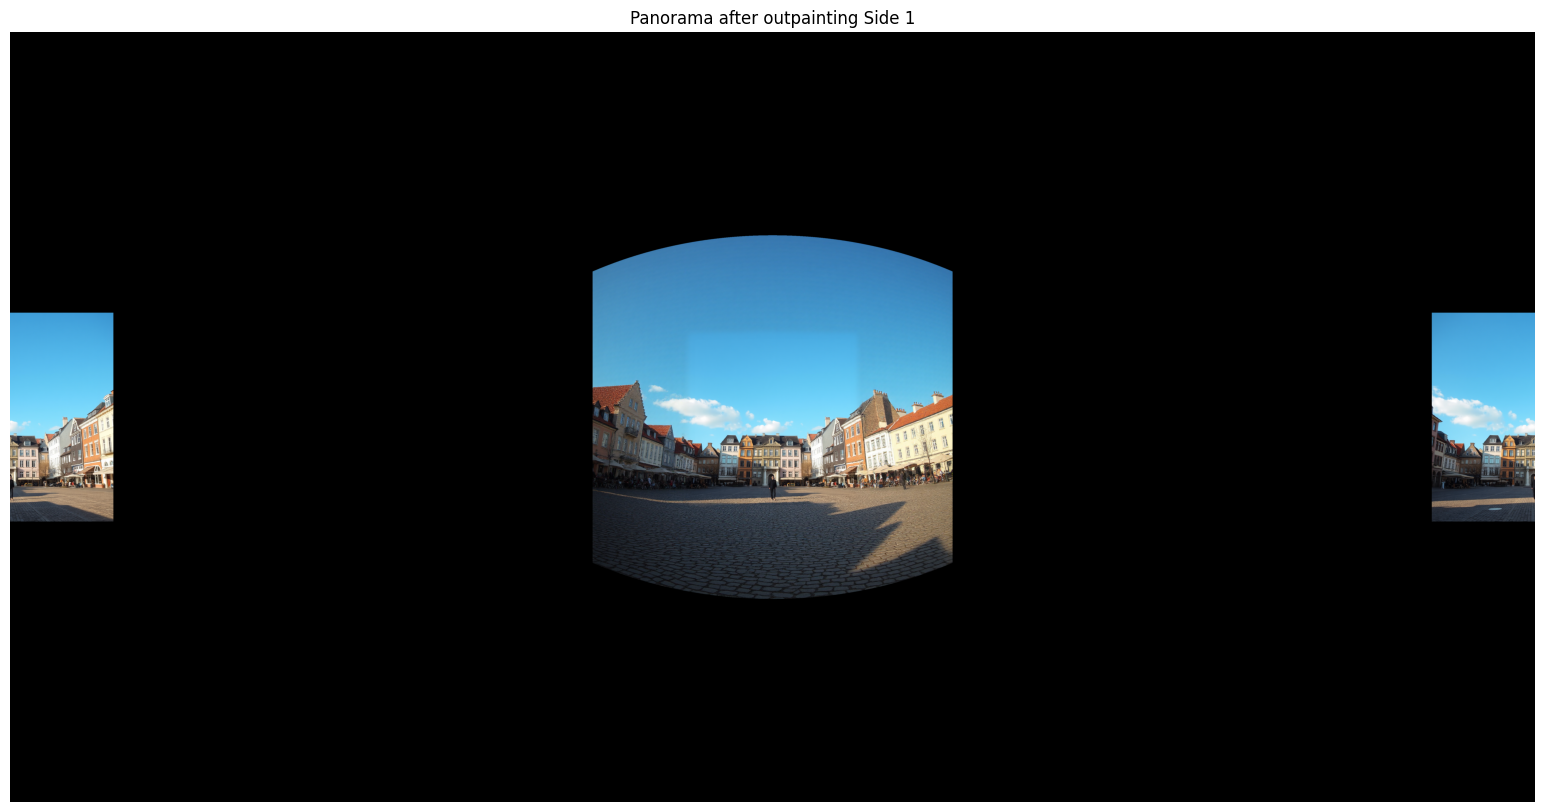

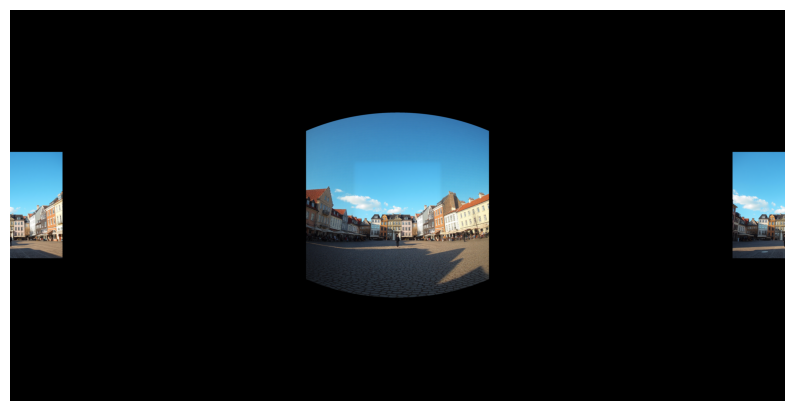

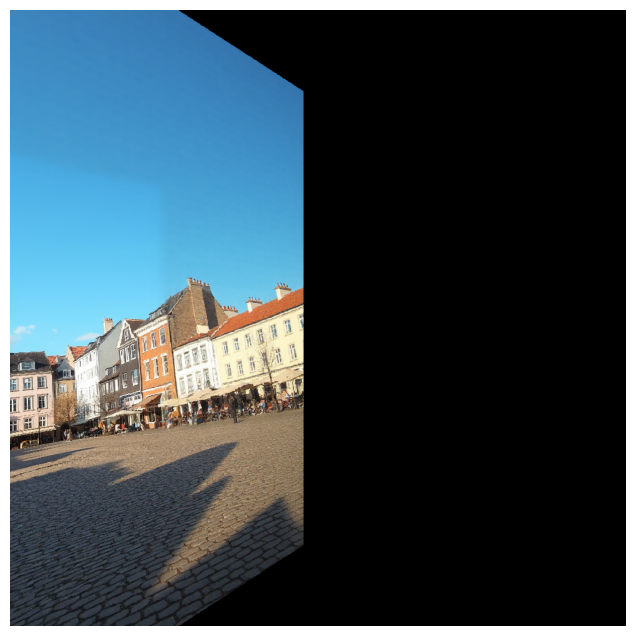

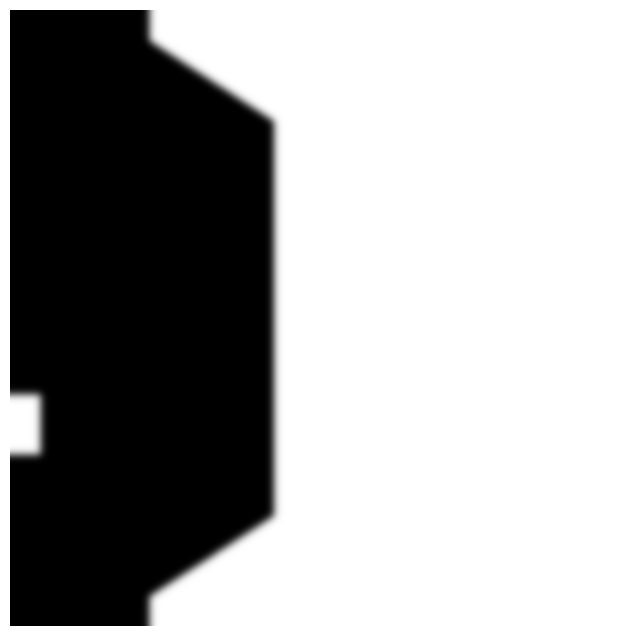

Render image shape: (1024, 1024)(1024, 1024)


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


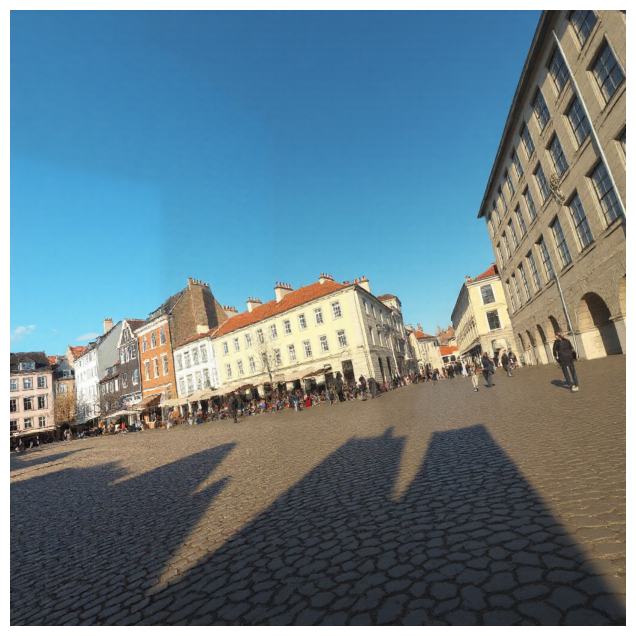

Mask min: 0.0, max: 1.0


/home/cedric/PanoramaGenInpaint/image_utils.py:553: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_x = world_x / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:554: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_y = world_y / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:554: RuntimeWarning: invalid value encountered in divide
  persp_ndc_y = world_y / world_z


Projected 2311279 pixels from perspective to equirect with yaw=45, pitch=0
Projected 2311279 pixels from perspective to equirect with yaw=45, pitch=0


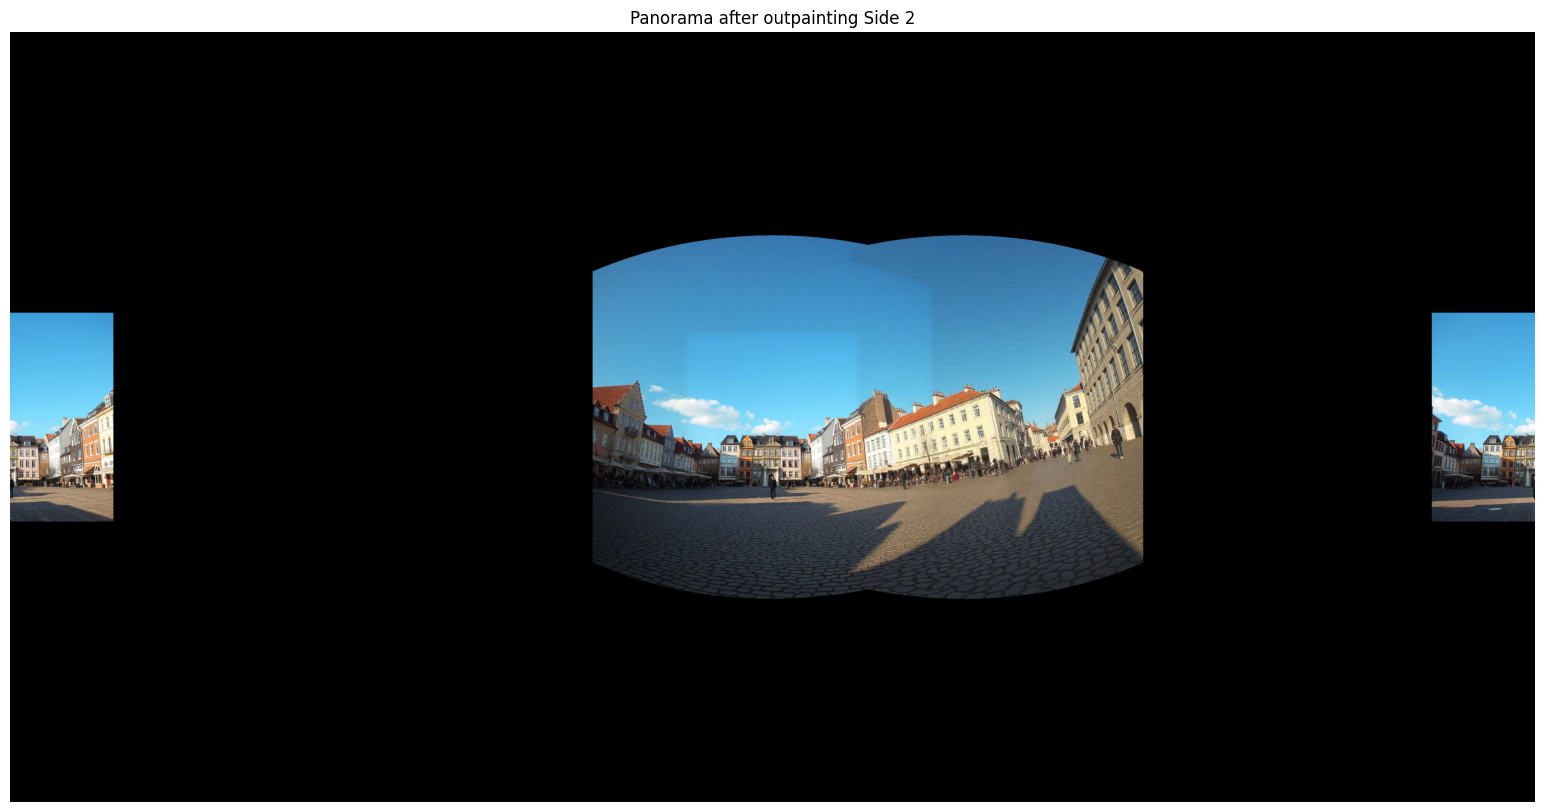

'\nfor idx,view in enumerate(side_views) : \n    mask = view[\'mask\']\n    mask[mask==255] = 1\n    #mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))\n    render_img = cv2.cvtColor(view[\'render\'], cv2.COLOR_BGR2RGB)\n    show_image_cv2(render_img)\n    render_img = cv2_to_pil(render_img)\n    \n    print(f"Render image shape: {render_img.size}{mask.shape}")\n    image = generate_outpaint(pipeline, render_img, mask,vis=True)\n    if idx == 1 : \n    \tbreak\n'

In [5]:
top_and_bottom_views = [all_views_data[0],all_views_data[3]]
side_views = all_views_data[6:]

'''
for view in top_and_bottom_views[:2] :
    mask = view['mask']
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    #show_image_cv2(new_mask)
    inital_pano = Image.open("initial_pano_with_back.png")
    initial_pano_np = np.array(inital_pano)
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)

    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt='floor of a city town square')
    final_pano = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=-view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=mask  # Original mask - only project where we outpainted
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(final_pano)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''


inital_pano = Image.open("initial_pano_with_back.png")
initial_pano_np = np.array(inital_pano)
output_size = 1024
'''
for view in top_and_bottom_views :
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                initial_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    
    mask = create_mask_from_black(render_img, threshold=10)
    
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    
    render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    if view['label'] == 'Top' : 
        prompt = 'Floor of a city town square'      
    else : 
        prompt = 'Sky of a city town square, no buildings'
    
    
	
    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt=prompt)
    image.save("outpainted_test.png")
    #image = Image.open("outpainted_test.png")
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=None,  # Original mask - only project where we outpainted,
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''
side_view_pano = Image.open("initial_pano_center.png")
side_view_pano_np = np.array(side_view_pano)
for idx,view in enumerate(side_views[:2]):
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                side_view_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    show_image_cv2(cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB))
    
    mask = create_mask_from_black(render_img, threshold=10)
    mask[mask==255] = 1
    #new_mask = mask*255
    new_mask = fix_inpaint_mask(mask*255)
    show_image_cv2(new_mask)
    
    
    render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    prompt = 'a city town square'      
	
    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt=prompt,num_steps=100,use_flux=True)
    image = composite_with_mask(
		torch.from_numpy(pil_to_cv2(render_img)).to('cuda:0').unsqueeze(0).float(),
		torch.from_numpy(pil_to_cv2(image)).to('cuda:0').unsqueeze(0).float(),
		mask=torch.from_numpy(new_mask).to('cuda:0').unsqueeze(0).unsqueeze(0).float(),
	)
    image = image[0].cpu().numpy().astype(np.uint8)
    image = cv2_to_pil(image)
    #image = generate_outpaint(pipeline, image, np.ones_like(new_mask),vis=True,num_steps=20,prompt=prompt)
    #image = Image.open("outpainted_test.png")
    cur_mask = new_mask 
    if idx >= 1 : 
        cur_mask = new_mask
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=cur_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )
    
    side_view_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        side_view_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=cur_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()

'''
for idx,view in enumerate(side_views) : 
    mask = view['mask']
    mask[mask==255] = 1
    #mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    
    print(f"Render image shape: {render_img.size}{mask.shape}")
    image = generate_outpaint(pipeline, render_img, mask,vis=True)
    if idx == 1 : 
    	break
'''